<a href="https://colab.research.google.com/github/ella00100/RenewableEnergyModel/blob/main/YSY04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('test_data.csv')
train = data.copy()
train = pd.DataFrame(train)

In [4]:
train['일자'] = pd.to_datetime(train['일자'])
train = train.rename(columns={'일자':'date'})
train = train.rename(columns={'구분1': 'type1'})
train = train.rename(columns={'발전소코드':'power_plant_code'})
train = train.rename(columns={'발전소용량(KW)':'power_plant_capacity'})
train = train.rename(columns={'합계':'sum'})

In [5]:
for col in train.columns:
    if train[col].dtype == 'object':
      if col != 'type1' and col != 'power_plant_code':
        train[col] = pd.to_numeric(train[col], errors='coerce')

In [6]:
train.fillna(0, inplace=True)

In [7]:
def update_label(value):
    if value == '실측':
        return 1
    elif value == '예측':
        return 0
    else:
        return value

train['type1'] = train['type1'].apply(update_label)

In [8]:
code_list = []

def split_dataframe_by_code(df, code_column):
    # Sort the DataFrame by the 'date' column
    df = df.sort_values('date')

    # Split the DataFrame by power plant code and store it in a dictionary
    data_dict = {}
    unique_codes = df[code_column].unique()
    for code in unique_codes:
        data_dict[code] = df[df[code_column] == code].copy()

    return data_dict


# '발전소코드' 열을 기준으로 데이터프레임을 분할
data_by_code = split_dataframe_by_code(train, 'power_plant_code')

# 분할된 데이터프레임에 자동으로 새로운 이름 지정
for i, (code, data) in enumerate(data_by_code.items()):
    new_name = f"code{i+1}"
    globals()[new_name] = data
    code_list.append(globals()[new_name])
    file_name = f"code{i+1}.csv"
    data.to_csv(file_name, index=False)

In [9]:
def calculate_diff_values(dataframe):
    diff_values = []
    time_columns = dataframe.columns[4:-1]  # 시간대 열의 범위

    for date in dataframe['date'].unique():
        temp_row = {'date': date}
        for time_col in time_columns:
            diff = dataframe[(dataframe['date'] == date) & (dataframe['type1'] == 1)][time_col].values[0] - dataframe[(dataframe['date'] == date) & (dataframe['type1'] == 0)][time_col].values[0]
            temp_row[time_col] = diff
        diff_values.append(temp_row)

    diff_df = pd.DataFrame(diff_values)
    return diff_df

In [10]:
diff_results=[]
for code_df in code_list:
    diff_df = calculate_diff_values(code_df)
    diff_results.append(diff_df)

diff_dataframes = []

for i, diff_df in enumerate(diff_results):
    filename = f"code{i+1}_diff.csv"
    diff_df.to_csv(filename, index=False)
    diff_dataframe_name = f"code{i+1}_diff"
    globals()[diff_dataframe_name] = diff_df
    diff_dataframes.append(diff_dataframe_name)

In [11]:
def plot_diff_values(filename):
    diff_df = pd.read_csv(filename)

    plt.figure(figsize=(10, 6))
    plt.title(f"{filename} - date - errorValue")
    plt.xlabel("date")
    plt.ylabel("error_value")
    plt.xticks(rotation=45)
    plt.grid(True)

    # 일자별로 그래프 그리기
    for date in diff_df['date'].unique():
        date_df = diff_df[diff_df['date'] == date]
        time_columns = date_df.columns[1:]  # 시간대 열 범위

        values = date_df.iloc[0, 1:].values
        plt.plot(time_columns, values, label=f"{date}")
    plt.legend()
    plt.show()

In [12]:
def divide_capacity(filenumber):
  origin_df = pd.read_csv(f"code{filenumber}.csv")
  diff_df = pd.read_csv(f"code{filenumber}_diff.csv")
  diff_divCapa_df = diff_df.copy()
  capacity = origin_df["power_plant_capacity"]

  diff_divCapa_df.iloc[:, 1:] = diff_divCapa_df.iloc[:, 1:] / capacity[0]
  diff_divCapa_df.to_csv(f"code{filenumber}_diff_divCapa.csv", index=False)

  return diff_divCapa_df

for i in range(1,170):
  divide_capacity(i)

def diff_divCapa_values(filename):
    code_diff_divCapa = pd.read_csv(filename)
    return code_diff_divCapa

for i in range(1, 170):
    file_path = f"code{i}_diff_divCapa.csv"
    code_diff_divCapa = diff_divCapa_values(file_path)
    globals()["code{}_diff_divCapa".format(i)] = code_diff_divCapa

In [13]:
def merge_code_data(*code_dfs):
    merged_df = code_dfs[0].copy()

    for code_df in code_dfs[1:]:
        merged_df['power_plant_code'] += ',' + code_df['power_plant_code']

        # 합치려는 열 범위 (0:00부터 23:00까지)
        time_columns = code_dfs[0].columns[3:-1]

        for col in time_columns:
            merged_df[col] += code_df[col]

    return merged_df

In [14]:
def generate_code_money(code_df, diff_div_df):
    code_money = pd.DataFrame(0, index=np.arange(31), columns=diff_div_df.columns)
    code_money['date'] = diff_div_df['date']

    for index in range(len(code_money)):
        for col in code_money.columns[1:-1]:
            value = abs(diff_div_df.loc[index, col])
            if value <= 0.06:
                code_money.loc[index, col] = code_df.loc[(code_df['date'] == code_money.loc[index, 'date']) & (code_df['type1'] == 1), col].values[0] * 4
            elif value <= 0.08:
                code_money.loc[index, col] = code_df.loc[(code_df['date'] == code_money.loc[index, 'date']), col].values[0] * 3

    code_money['total'] = code_money.iloc[:, 1:-1].sum(axis=1)
    return code_money

In [15]:
def code_money(*code_dfs):
    merged_df = merge_code_data(*code_dfs)

    diff_df = calculate_diff_values(merged_df)
    diff_div_df = diff_df.copy()
    diff_div_df.iloc[:, 1:] = diff_div_df.iloc[:, 1:] / merged_df['power_plant_capacity'][0]
    diff_div_df.to_csv('diff_div.csv', index=False)

    code_money_df = generate_code_money(merged_df, diff_div_df)

    return code_money_df

#여기부터


In [16]:
def find_max_capacity_df_name(code_list):
    max_capacity_df_name = None
    max_capacity = 0

    for code in code_list:
        file_path = f"code{code}.csv"  # CSV 파일 경로

        df = pd.read_csv(file_path)

        if df['power_plant_capacity'].iloc[0] > max_capacity:
            max_capacity = df['power_plant_capacity'].iloc[0]
            max_capacity_df_name = f"code{code}"

    return max_capacity_df_name

In [17]:
code_diff_mean_dict = {}

for code in range(1, 170):
    code_diff_filename = f'code{code}_diff.csv'
    code_diff_df = pd.read_csv(code_diff_filename)

    mean_values = code_diff_df.iloc[:, 1:].mean()

    code_diff_mean_df = pd.DataFrame(mean_values, columns=['mean'])

    code_diff_mean_df.to_csv(f'code{code}_diff_mean.csv', index=False)

    code_diff_mean_dict[f'code{code}_diff_mean'] = code_diff_mean_df


for code, df in code_diff_mean_dict.items():
    globals()[code] = df

In [18]:
dfs = list(code_diff_mean_dict.values())

code_diff_mean = pd.concat(dfs, axis=1)
code_diff_mean = pd.DataFrame(code_diff_mean)
new_columns = [f'code{i}_diff_mean' for i in range(1, 170)]
code_diff_mean.columns = new_columns

In [19]:
code_diff_mean = code_diff_mean.T

In [20]:
code_diff_mean

,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
code1_diff_mean,-0.917097,-0.924516,-0.930645,-0.938065,-0.930000,-0.922258,-0.947742,-1.910645,-6.638065,-5.812258,...,2.045806,-10.854194,-8.669032,-4.499355,-26.644839,4.379032,14.246774,15.015806,-0.804516,-0.916774
code2_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.861613,-8.203548,-15.979032,-19.068065,...,-3.417742,7.896774,5.253871,-0.951290,-2.302258,-0.019355,0.000000,0.000000,0.000000,0.000000
code3_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.052258,-8.199355,-13.300968,-14.916129,...,-6.137097,10.313548,5.757419,-0.699032,-2.391290,-0.039677,0.000000,0.000000,0.000000,0.000000
code4_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.434194,-15.815484,-1.830000,4.228065,...,-3.583226,20.448065,9.034839,-2.273871,-3.428065,-0.061935,0.000000,0.000000,0.000000,0.000000
code5_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.916452,-21.444194,-50.133871,-81.387097,...,-2.854194,21.595806,-8.560323,-7.685161,-2.791613,-0.026129,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
code165_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.266129,-5.389032,-10.176774,-20.742903,...,-36.267419,-14.208065,-1.423871,0.338387,1.057742,0.000000,0.000000,0.000000,0.000000,0.000000
code166_diff_mean,27.083548,-0.636774,-0.626452,-0.623871,-0.647097,-0.612258,-0.902258,-0.743871,-3.110968,0.346452,...,8.379032,1.344194,-6.726129,0.049355,-0.648065,-0.653871,-28.423226,-20.234839,1.796129,10.480968
code167_diff_mean,9.930968,-2.141935,-2.115806,-2.089677,-2.065806,-2.054516,-2.266129,-2.324516,-7.828065,1.101935,...,9.095484,-8.358065,-16.282258,-109.583871,-293.398065,-281.320645,4.717419,165.632258,263.098710,194.977419
code168_diff_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.129032,47.645484,173.853226,387.707742,...,780.500645,717.664194,467.693548,206.318065,20.805161,0.096452,0.000000,0.000000,0.000000,0.000000


In [21]:
code_divCapa_mean_dict = {}

for code in range(1, 170):
    code_diff_mean_filename = f'code{code}_diff_mean.csv'
    code_diff_mean_df = pd.read_csv(code_diff_mean_filename)
    code_filename = f'code{code}.csv'
    code_df = pd.read_csv(code_filename)
    divCapa_mean = code_diff_mean_df['mean'] / code_df['power_plant_capacity'][0]
    code_divCapa_mean_dict[f'code{code}_divCapa_mean'] = divCapa_mean

code_divCapa_mean_df = pd.DataFrame(code_divCapa_mean_dict)

In [22]:
code_divCapa_mean_df = code_divCapa_mean_df.T

Cluster 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169]
Cluster 2: [86, 134, 143, 168]
Cluster 3: [91]


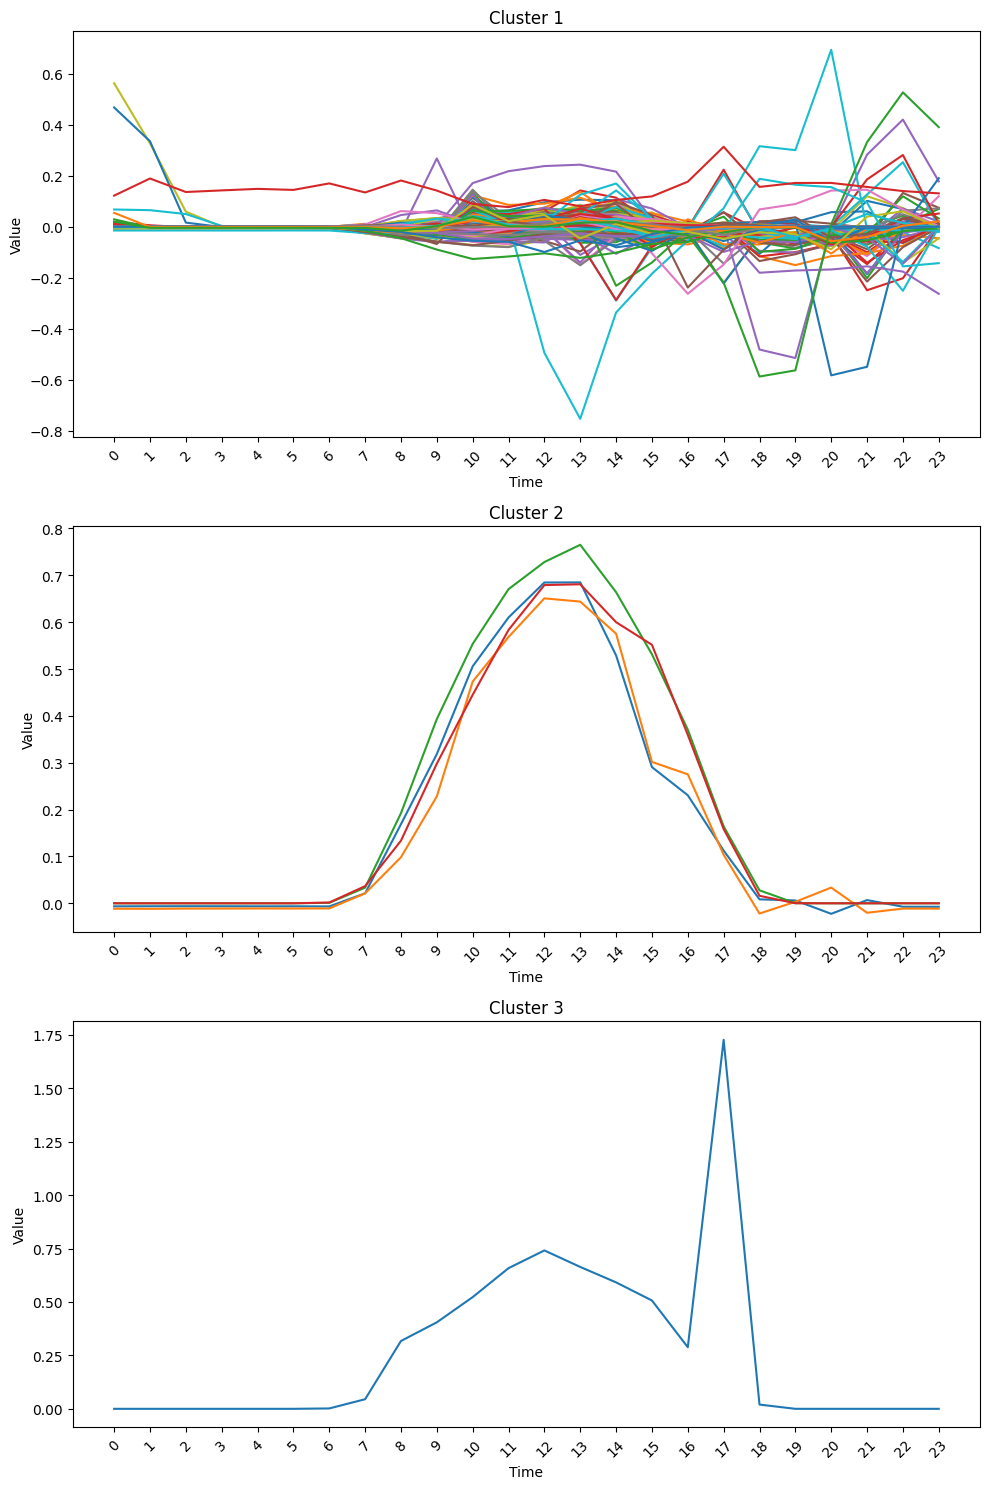

In [23]:
def perform_kmeans_clustering(data, num_clusters):
    # K-Means 클러스터링 수행
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)

    # 클러스터링 결과 저장을 위한 빈 리스트 생성
    cluster_lists = [[] for _ in range(num_clusters)]

    # 클러스터링 결과 출력 및 저장
    for i in range(num_clusters):
        cluster_indices = [idx for idx, cluster in enumerate(clusters) if cluster == i]
        code_indices = [code + 1 for code in cluster_indices]  # 코드 번호로 변환
        print(f"Cluster {i+1}: {code_indices}")

        # 클러스터별로 코드 인덱스 저장
        cluster_lists[i] = code_indices

    return clusters, cluster_lists

def plot_cluster_graphs(data, clusters, num_clusters):
    fig, axes = plt.subplots(num_clusters, 1, figsize=(10, num_clusters * 5))

    for i in range(num_clusters):
        cluster_indices = [idx for idx, cluster in enumerate(clusters) if cluster == i]
        for idx in cluster_indices:
            code_data = data.iloc[idx, :]
            x = range(len(code_data))
            y = code_data.values

            ax = axes[i] if num_clusters > 1 else axes
            ax.plot(x, y)
            ax.set_title(f"Cluster {i+1}")
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')

            # x축 레이블 설정 (0:00 ~ 23:00)
            ax.set_xticks(x)
            ax.set_xticklabels(data.columns, rotation=45)

    plt.tight_layout()
    plt.show()

# 클러스터링 수행
num_clusters = 3
clusters, cluster_lists = perform_kmeans_clustering(code_divCapa_mean_df.values, num_clusters)

# 클러스터링 결과 그래프 표현
plot_cluster_graphs(code_divCapa_mean_df, clusters, num_clusters)

##cluster 결과로 1차 실행

In [24]:
set1_list = []
set2_list = []
set3_list = []

In [25]:
code_list1 = cluster_lists[0]
code_list2 = cluster_lists[1]
code_list3 = cluster_lists[2]

for i in range(3):
    list_name = f'code_list{i+1}'
    result = find_max_capacity_df_name(globals()[list_name])
    set_name = f'set{i+1}'
    globals()[set_name] = result

set1_p = set1
set2_p = set2
set3_p = set3

set1 = pd.read_csv(f'{set1}.csv')
set2 = pd.read_csv(f'{set2}.csv')
set3 = pd.read_csv(f'{set3}.csv')

set1_list.append(set1_p)
set2_list.append(set2_p)
set3_list.append(set3_p)

In [26]:
print(set1_p, set2_p, set3_p)

code73 code86 code91


In [27]:
def find_correlated_rows(df, target_row, num_rows=5):
    correlations = df.corrwith(df.loc[target_row], axis=1)
    correlations = correlations.drop(target_row)
    most_negative_rows = correlations.nsmallest(num_rows).index
    most_positive_rows = correlations.nlargest(num_rows).index

    negative_results = {}
    positive_results = {}

    for row in most_negative_rows:
        correlation = correlations[row]
        negative_results[row] = correlation

    for row in most_positive_rows:
        correlation = correlations[row]
        positive_results[row] = correlation

    return negative_results, positive_results

In [28]:
def find_most_negative_correlation(code_divCapa_mean, column):
    negative_correlations, positive_correlations = find_correlated_rows(code_divCapa_mean, column, 2)
    negative_rows = list(negative_correlations.keys())

    if len(negative_rows) > 0 and negative_rows[0].startswith('code'):
        return negative_rows[0].split('_')[0]

    if len(negative_rows) > 1:
        return negative_rows[1].split('_')[0]

    positive_rows = list(positive_correlations.keys())

    if len(positive_rows) > 0:
        min_positive_correlation = min(positive_correlations.values())
        min_positive_rows = [row for row, correlation in positive_correlations.items() if correlation == min_positive_correlation]
        min_positive_rows = [row for row in min_positive_rows if row not in [set1_nega, set2_nega, set3_nega]]
        if len(min_positive_rows) > 0:
            return min_positive_rows[0].split('_')[0]

    return None

In [29]:
code_divCapa_mean = code_divCapa_mean_df

In [30]:
set1_nega = find_most_negative_correlation(code_divCapa_mean, f'{set1_p}_divCapa_mean')
set2_nega = find_most_negative_correlation(code_divCapa_mean, f'{set2_p}_divCapa_mean')
set3_nega = find_most_negative_correlation(code_divCapa_mean, f'{set3_p}_divCapa_mean')

set1_nega_df = pd.read_csv(f'{set1_nega}.csv')
set2_nega_df = pd.read_csv(f'{set2_nega}.csv')
set3_nega_df = pd.read_csv(f'{set3_nega}.csv')

set1 = merge_code_data(set1, set1_nega_df)
set2 = merge_code_data(set2, set2_nega_df)
set3 = merge_code_data(set3, set3_nega_df)

set1_diff = calculate_diff_values(set1)
set2_diff = calculate_diff_values(set2)
set3_diff = calculate_diff_values(set3)

In [31]:
datasets = [set1, set2, set3]

for i, dataset in enumerate(datasets, start=1):
    filename = f'set{i}.csv'
    dataset.to_csv(filename, index=False)

datasets = [set1_diff, set2_diff, set3_diff]

for i, dataset in enumerate(datasets, start=1):
    filename = f'set{i}_diff.csv'
    dataset.to_csv(filename, index=False)

In [32]:
for i in range(1, 4):
    set_diff_name = f'set{i}_diff'
    set_mean_name = f'set{i}_diff_mean'

    set_diff_df = globals()[set_diff_name]
    mean_values = set_diff_df.iloc[:, 1:].mean()
    set_mean_df = pd.DataFrame(mean_values, columns=['mean'])

    set_mean_df.to_csv(f'{set_mean_name}.csv', index=False)
    globals()[set_mean_name] = set_mean_df

In [33]:
set1_n = int(set1_p[4:])
set2_n = int(set2_p[4:])
set3_n = int(set3_p[4:])

set1_nega_n = int(set1_nega[4:])
set2_nega_n = int(set2_nega[4:])
set3_nega_n = int(set3_nega[4:])

In [34]:
set1_list.append(set1_nega)
set2_list.append(set1_nega)
set3_list.append(set1_nega)

In [35]:
code_diff_mean = code_diff_mean.T
code_diff_mean = code_diff_mean.drop(columns=[f'code{set1_n}_diff_mean', f'code{set2_n}_diff_mean', f'code{set3_n}_diff_mean',
f'code{set1_nega_n}_diff_mean', f'code{set2_nega_n}_diff_mean', f'code{set3_nega_n}_diff_mean'], inplace=False)

code_diff_mean['set1_diff_mean'] = set1_diff_mean['mean']
code_diff_mean['set2_diff_mean'] = set2_diff_mean['mean']
code_diff_mean['set3_diff_mean'] = set3_diff_mean['mean']


In [36]:
code_diff_mean

,code1_diff_mean,code2_diff_mean,code3_diff_mean,code4_diff_mean,code5_diff_mean,code6_diff_mean,code7_diff_mean,code8_diff_mean,code9_diff_mean,code10_diff_mean,...,code162_diff_mean,code163_diff_mean,code164_diff_mean,code166_diff_mean,code167_diff_mean,code168_diff_mean,code169_diff_mean,set1_diff_mean,set2_diff_mean,set3_diff_mean
0:00,-0.917097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.050645,...,0.000000,-3.185806,-0.986774,27.083548,9.930968,0.000000,146.478387,-9.732258,-18.889032,0.000000
1:00,-0.924516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.991290,...,0.000000,-2.903548,-0.987419,-0.636774,-2.141935,0.000000,226.983548,-8.356774,-18.285484,0.000000
2:00,-0.930645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.986774,...,0.000000,-2.838387,-0.989355,-0.626452,-2.115806,0.000000,163.397742,-8.121290,-18.115806,0.000000
3:00,-0.938065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.908387,...,0.000000,-2.840968,-0.973871,-0.623871,-2.089677,0.000000,170.968065,-7.808710,-18.270968,0.000000
4:00,-0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.033548,...,0.000000,-2.841290,-0.983871,-0.647097,-2.065806,0.000000,178.167742,-7.306129,-18.739677,0.000000
5:00,-0.922258,0.000000,0.000000,0.000000,0.000000,-0.000323,0.000000,0.000000,0.000000,-4.325161,...,0.000000,-2.801613,-0.980968,-0.612258,-2.054516,0.000000,173.311935,-7.158387,-18.605161,0.000000
6:00,-0.947742,-0.861613,-1.052258,-2.434194,-0.916452,-1.636452,-0.504839,-0.313548,-0.772903,-4.508710,...,0.059677,-2.830645,-0.986129,-0.902258,-2.266129,2.129032,203.899677,-10.234194,-19.278710,1.049032
7:00,-1.910645,-8.203548,-8.199355,-15.815484,-21.444194,-18.519032,-3.472258,-3.483226,-21.285806,-3.331935,...,1.101290,-3.681935,-1.820000,-0.743871,-2.324516,47.645484,161.217419,-56.425806,62.504194,41.450968
8:00,-6.638065,-15.979032,-13.300968,-1.830000,-50.133871,-44.669032,-18.764194,-12.858387,-60.866129,-9.820323,...,0.005161,-8.550645,-2.063226,-3.110968,-7.828065,173.853226,217.414516,-64.346452,489.659032,306.379677
9:00,-5.812258,-19.068065,-14.916129,4.228065,-81.387097,-76.592258,-36.573548,-23.908387,-114.199677,-26.081613,...,-2.970000,-8.015484,1.610000,0.346452,1.101935,387.707742,170.162258,-57.293548,933.470323,371.532581


In [37]:
set1_diff_divCapa = set1_diff.copy()
set1_diff_divCapa.iloc[:, 1:] = set1_diff_divCapa.iloc[:, 1:] / set1['power_plant_capacity'].iloc[0]
set1_diff_divCapa.to_csv('set1_diff_divCapa.csv', index=False)

set2_diff_divCapa = set2_diff.copy()
set2_diff_divCapa.iloc[:, 1:] = set2_diff_divCapa.iloc[:, 1:] / set2['power_plant_capacity'].iloc[0]
set2_diff_divCapa.to_csv('set2_diff_divCapa.csv', index=False)

set3_diff_divCapa = set3_diff.copy()
set3_diff_divCapa.iloc[:, 1:] = set3_diff_divCapa.iloc[:, 1:] / set3['power_plant_capacity'].iloc[0]
set3_diff_divCapa.to_csv('set3_diff_divCapa.csv', index=False)

In [38]:
code_divCapa_mean= code_divCapa_mean_df.T
set_divCapa_mean_dict = {}
column_names = []

for code in range(1, 4):
    set_diff_mean_filename = f'set{code}_diff_mean.csv'
    set_diff_mean_df = pd.read_csv(set_diff_mean_filename)
    set_filename = f'set{code}.csv'
    set_df = pd.read_csv(set_filename)

    divCapa_mean = set_diff_mean_df['mean'] / set_df['power_plant_capacity'][0]
    column_name = f'set{code}_divCapa_mean'
    column_names.append(column_name)
    set_divCapa_mean_dict[column_name] = divCapa_mean

In [39]:
code_divCapa_mean

,code1_divCapa_mean,code2_divCapa_mean,code3_divCapa_mean,code4_divCapa_mean,code5_divCapa_mean,code6_divCapa_mean,code7_divCapa_mean,code8_divCapa_mean,code9_divCapa_mean,code10_divCapa_mean,...,code160_divCapa_mean,code161_divCapa_mean,code162_divCapa_mean,code163_divCapa_mean,code164_divCapa_mean,code165_divCapa_mean,code166_divCapa_mean,code167_divCapa_mean,code168_divCapa_mean,code169_divCapa_mean
0,-0.003676,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004748,...,0.000000,0.000000e+00,0.000000,-0.006436,-0.001991,0.000000,0.054280,0.019894,0.000000,0.122065
1,-0.003706,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004678,...,0.000000,0.000000e+00,0.000000,-0.005866,-0.001992,0.000000,-0.001276,-0.004291,0.000000,0.189153
2,-0.003730,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004673,...,0.000000,0.000000e+00,0.000000,-0.005734,-0.001996,0.000000,-0.001256,-0.004238,0.000000,0.136165
3,-0.003760,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004581,...,0.000000,0.000000e+00,0.000000,-0.005739,-0.001965,0.000000,-0.001250,-0.004186,0.000000,0.142473
4,-0.003728,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004728,...,0.000000,0.000000e+00,0.000000,-0.005740,-0.001985,0.000000,-0.001297,-0.004138,0.000000,0.148473
5,-0.003697,0.000000,0.000000,0.000000,0.000000,-1.649860e-07,0.000000,0.000000,0.000000,-0.005069,...,0.000000,0.000000e+00,0.000000,-0.005660,-0.001979,0.000000,-0.001227,-0.004116,0.000000,0.144427
6,-0.003799,-0.000863,-0.001054,-0.001644,-0.000338,-8.369740e-04,-0.000457,-0.000474,-0.000391,-0.005284,...,0.000289,3.343620e-05,0.000121,-0.005718,-0.001989,-0.000537,-0.001808,-0.004540,0.001636,0.169916
7,-0.007659,-0.008218,-0.008214,-0.010683,-0.007917,-9.471682e-03,-0.003146,-0.005271,-0.010770,-0.003905,...,0.005446,5.966067e-05,0.002238,-0.007438,-0.003671,-0.010865,-0.001491,-0.004656,0.036622,0.134348
8,-0.026608,-0.016008,-0.013325,-0.001236,-0.018509,-2.284627e-02,-0.017003,-0.019458,-0.030797,-0.011510,...,0.003732,8.045012e-03,0.000010,-0.017274,-0.004162,-0.020518,-0.006235,-0.015681,0.133630,0.181179
9,-0.023297,-0.019102,-0.014943,0.002856,-0.030048,-3.917362e-02,-0.033141,-0.036180,-0.057783,-0.030569,...,0.005427,6.484000e-04,-0.006036,-0.016193,0.003248,-0.041820,0.000694,0.002207,0.298007,0.141802


In [40]:
set_divCapa_mean_dict

{'set1_divCapa_mean': 0    -0.001600
 1    -0.001374
 2    -0.001335
 3    -0.001284
 4    -0.001201
 5    -0.001177
 6    -0.001682
 7    -0.009275
 8    -0.010577
 9    -0.009418
 10    0.029208
 11    0.016705
 12    0.043857
 13    0.054887
 14    0.068593
 15    0.003297
 16   -0.004444
 17   -0.028767
 18   -0.046816
 19   -0.049489
 20   -0.012502
 21   -0.185497
 22   -0.003122
 23   -0.002285
 Name: mean, dtype: float64,
 'set2_divCapa_mean': 0    -0.005346
 1    -0.005175
 2    -0.005127
 3    -0.005171
 4    -0.005303
 5    -0.005265
 6    -0.005456
 7     0.017689
 8     0.138572
 9     0.264170
 10    0.420577
 11    0.508688
 12    0.567806
 13    0.568905
 14    0.440163
 15    0.242548
 16    0.190297
 17    0.092654
 18    0.006881
 19    0.004968
 20   -0.018436
 21    0.005624
 22   -0.005995
 23   -0.006088
 Name: mean, dtype: float64,
 'set3_divCapa_mean': 0     0.000000
 1     0.000000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000000
 6     0.000542

In [41]:
code_divCapa_mean = code_divCapa_mean.drop(columns=[f'code{set1_n}_divCapa_mean', f'code{set2_n}_divCapa_mean', f'code{set3_n}_divCapa_mean',
                                                    f'code{set1_nega_n}_divCapa_mean', f'code{set2_nega_n}_divCapa_mean', f'code{set3_nega_n}_divCapa_mean'], inplace=False)

code_divCapa_mean['set1_divCapa_mean'] = set_divCapa_mean_dict['set1_divCapa_mean']
code_divCapa_mean['set2_divCapa_mean'] = set_divCapa_mean_dict['set2_divCapa_mean']
code_divCapa_mean['set3_divCapa_mean'] = set_divCapa_mean_dict['set3_divCapa_mean']


In [42]:
code_divCapa_mean

,code1_divCapa_mean,code2_divCapa_mean,code3_divCapa_mean,code4_divCapa_mean,code5_divCapa_mean,code6_divCapa_mean,code7_divCapa_mean,code8_divCapa_mean,code9_divCapa_mean,code10_divCapa_mean,...,code162_divCapa_mean,code163_divCapa_mean,code164_divCapa_mean,code166_divCapa_mean,code167_divCapa_mean,code168_divCapa_mean,code169_divCapa_mean,set1_divCapa_mean,set2_divCapa_mean,set3_divCapa_mean
0,-0.003676,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004748,...,0.000000,-0.006436,-0.001991,0.054280,0.019894,0.000000,0.122065,-0.001600,-0.005346,0.000000
1,-0.003706,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004678,...,0.000000,-0.005866,-0.001992,-0.001276,-0.004291,0.000000,0.189153,-0.001374,-0.005175,0.000000
2,-0.003730,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004673,...,0.000000,-0.005734,-0.001996,-0.001256,-0.004238,0.000000,0.136165,-0.001335,-0.005127,0.000000
3,-0.003760,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004581,...,0.000000,-0.005739,-0.001965,-0.001250,-0.004186,0.000000,0.142473,-0.001284,-0.005171,0.000000
4,-0.003728,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.004728,...,0.000000,-0.005740,-0.001985,-0.001297,-0.004138,0.000000,0.148473,-0.001201,-0.005303,0.000000
5,-0.003697,0.000000,0.000000,0.000000,0.000000,-1.649860e-07,0.000000,0.000000,0.000000,-0.005069,...,0.000000,-0.005660,-0.001979,-0.001227,-0.004116,0.000000,0.144427,-0.001177,-0.005265,0.000000
6,-0.003799,-0.000863,-0.001054,-0.001644,-0.000338,-8.369740e-04,-0.000457,-0.000474,-0.000391,-0.005284,...,0.000121,-0.005718,-0.001989,-0.001808,-0.004540,0.001636,0.169916,-0.001682,-0.005456,0.000542
7,-0.007659,-0.008218,-0.008214,-0.010683,-0.007917,-9.471682e-03,-0.003146,-0.005271,-0.010770,-0.003905,...,0.002238,-0.007438,-0.003671,-0.001491,-0.004656,0.036622,0.134348,-0.009275,0.017689,0.021427
8,-0.026608,-0.016008,-0.013325,-0.001236,-0.018509,-2.284627e-02,-0.017003,-0.019458,-0.030797,-0.011510,...,0.000010,-0.017274,-0.004162,-0.006235,-0.015681,0.133630,0.181179,-0.010577,0.138572,0.158373
9,-0.023297,-0.019102,-0.014943,0.002856,-0.030048,-3.917362e-02,-0.033141,-0.036180,-0.057783,-0.030569,...,-0.006036,-0.016193,0.003248,0.000694,0.002207,0.298007,0.141802,-0.009418,0.264170,0.192051


#반복

In [43]:
for i in range(1, 163):
    set_num = i % 3 + 1
    set_diff_name = f'set{set_num}_diff'
    set_mean_name = f'set{set_num}_diff_mean'

    # set_nega에 대한 작업
    code_divCapa_mean = code_divCapa_mean.T
    set_nega = find_most_negative_correlation(code_divCapa_mean, f'set{set_num}_divCapa_mean')

    if set_num == 1:
        set1_list.append(set_nega)
    elif set_num == 2:
        set2_list.append(set_nega)
    elif set_num == 3:
        set3_list.append(set_nega)

    set_nega_df = pd.read_csv(f'{set_nega}.csv')
    globals()[f'set{set_num}'] = merge_code_data(globals()[f'set{set_num}'], set_nega_df)
    globals()[f'set{set_num}'].to_csv(f'set{set_num}.csv', index=False)

    # set_diff 생성
    set_diff = calculate_diff_values(globals()[f'set{set_num}'])
    set_diff.to_csv(f'{set_diff_name}.csv', index=False)

    # set_diff_mean 생성
    mean_value = set_diff.iloc[:, 1:].mean()
    set_diff_mean = pd.DataFrame(mean_value, columns=['mean'])
    set_diff_mean.to_csv(f'{set_mean_name}.csv', index=False)

    # set_diff_divCapa 생성
    set_diff_divCapa = set_diff.copy()
    set_diff_divCapa.iloc[:, 1:] = set_diff_divCapa.iloc[:, 1:] / globals()[f'set{set_num}']['power_plant_capacity'].iloc[0]
    set_diff_divCapa.to_csv(f'{set_num}_diff_divCapa.csv', index=False)

    # set_divCapa_mean 생성
    mean_values = set_diff_divCapa.iloc[:, 1:].mean()
    set_divCapa_mean = pd.DataFrame(mean_values, columns=['mean'])
    set_divCapa_mean.to_csv(f'{set_num}_divCapa_mean.csv', index=False)

    # code_diff_mean 업데이트
    set_nega_n = int(set_nega[4:])
    code_diff_mean = code_diff_mean.drop(columns=[f'set{set_num}_diff_mean', f'code{set_nega_n}_diff_mean'])
    code_diff_mean[f'set{set_num}_diff_mean'] = set_diff_mean['mean']

    # code_divCapa_mean 업데이트
    code_divCapa_mean = code_divCapa_mean.T
    code_divCapa_mean = code_divCapa_mean.drop(columns=[f'set{set_num}_divCapa_mean', f'code{set_nega_n}_divCapa_mean'])
    code_divCapa_mean[f'set{set_num}_divCapa_mean'] = set_divCapa_mean['mean']

In [44]:
code_diff_mean

,code169_diff_mean,set2_diff_mean,set3_diff_mean,set1_diff_mean
0:00,146.478387,-215.161290,0.344839,-27.671935
1:00,226.983548,-181.144194,-4.418065,-54.203226
2:00,163.397742,-46.910000,-4.104194,-31.662258
3:00,170.968065,-28.517419,-3.713871,-20.679355
4:00,178.167742,-27.225161,-3.793548,-20.265161
5:00,173.311935,-26.596129,-3.743548,-20.198710
6:00,203.899677,-35.459355,-13.365484,-28.693548
7:00,161.217419,39.704839,-17.187419,-69.583871
8:00,217.414516,441.433548,137.943871,-45.671290
9:00,170.162258,824.016129,-99.814194,111.739032


In [45]:
print(set1_list)
print(set2_list)
print(set3_list)

['code73', 'code165', 'code15', 'code3', 'code6', 'code9', 'code12', 'code17', 'code20', 'code23', 'code26', 'code29', 'code32', 'code35', 'code38', 'code41', 'code44', 'code47', 'code50', 'code53', 'code56', 'code60', 'code63', 'code66', 'code69', 'code74', 'code77', 'code80', 'code83', 'code87', 'code90', 'code94', 'code97', 'code100', 'code103', 'code106', 'code109', 'code112', 'code115', 'code118', 'code121', 'code124', 'code127', 'code130', 'code133', 'code136', 'code139', 'code142', 'code145', 'code148', 'code151', 'code154', 'code158', 'code161', 'code164', 'code168']
['code86', 'code165', 'code13', 'code1', 'code4', 'code7', 'code10', 'code14', 'code18', 'code21', 'code24', 'code27', 'code30', 'code33', 'code36', 'code39', 'code42', 'code45', 'code48', 'code51', 'code54', 'code58', 'code61', 'code64', 'code67', 'code70', 'code75', 'code78', 'code81', 'code84', 'code88', 'code92', 'code95', 'code98', 'code101', 'code104', 'code107', 'code110', 'code113', 'code116', 'code119', 'c

In [46]:
set3_list.append('code169')

In [47]:
print(len(set1_list))
print(len(set2_list))
print(len(set3_list))

56
56
57


In [53]:
set3 = merge_code_data(set3, code169)

In [54]:
set1_money = code_money(set1)
set2_money = code_money(set2)
set3_money = code_money(set3)

In [55]:
total_money = set1_money + set2_money + set3_money
print(total_money)

                              date     0:00     1:00     2:00    3:00    4:00  \
0   2023-03-012023-03-012023-03-01  1527.56  1373.84  1205.56  484.56  373.48   
1   2023-03-022023-03-022023-03-02  1325.04   968.84   428.32  338.52  334.96   
2   2023-03-032023-03-032023-03-03  3952.08  2949.68  1446.48  424.88  308.40   
3   2023-03-042023-03-042023-03-04  3428.64  1962.68   607.36  296.64  276.92   
4   2023-03-052023-03-052023-03-05  3012.16  2116.68   446.12  327.52  325.72   
5   2023-03-062023-03-062023-03-06  2930.72  1859.28   509.52  196.72  177.88   
6   2023-03-072023-03-072023-03-07   444.60   303.28   298.80  297.48  292.08   
7   2023-03-082023-03-082023-03-08   417.00   151.60   147.92  147.68  147.72   
8   2023-03-092023-03-092023-03-09  1636.56  1407.96  1236.28  521.48  401.84   
9   2023-03-102023-03-102023-03-10  1474.96   498.44   287.08  277.00  273.12   
10  2023-03-112023-03-112023-03-11  2728.64  2159.56   397.96  317.76  316.12   
11  2023-03-122023-03-122023